# **Building a Convolutional Neural Network with Keras**

In [ ]:
#Tensorflow version

import tensorflow as tf
print(tf.__version__)

2.9.0


In [ ]:
#Importing libraries

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Dense, Flatten, BatchNormalization, Dropout, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
import matplotlib.pyplot as plt
from keras.applications.efficientnet import EfficientNetB0
from keras.preprocessing import image
#from keras.preprocessing.image import load_img
from keras.models import Sequential
import numpy as np
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255) #Normalize the pixel values
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_dir = os.path.join('path_to/dataset/training/')
validation_dir = os.path.join('path_to/dataset/validation/')

In [ ]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(124, 124),
    batch_size=32,
    class_mode='binary',
    )

val_data = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(124,124),
    batch_size=32,
    class_mode='binary',
    )

Found 9506 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential([

    # First convolution layer
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(124, 124, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Second convolution layer
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Third convolution layer
    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),


    # Flatten the pooled feature maps
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.5),

    # Fully connected hidden layer
    tf.keras.layers.Dense(96, activation='relu'),
   # tf.keras.layers.Dense(100, activation='relu'),
    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
#print model summary

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 124, 122, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 62, 61, 32)       0         
 2D)                                                             
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 59, 64)        6208      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 29, 64)       0         
 2D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 31, 27, 128)       24704     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 13, 128)     

In [ ]:
#Performance evaluation Metrics delcaration

from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax,Nadam, Ftrl, Adadelta
from tensorflow.keras.metrics import SensitivityAtSpecificity,SpecificityAtSensitivity,Recall,Precision, AUC

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),  #Adamax, 3e-4
              metrics=['accuracy',SensitivityAtSpecificity(0.5),SpecificityAtSensitivity(0.5),Recall(0.5),Precision(0.5), AUC(num_thresholds=200,curve='ROC')])


In [ ]:
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.99):
            print("\n Reached 99% accuracy so cancelling training!")
            self.model.stop_training=True

mycallback=mycallback()

In [ ]:
#Model Execution

from keras.callbacks import ModelCheckpoint, EarlyStopping

# Initializing Device Specification
device_spec = tf.DeviceSpec(job ="localhost", replica = 0, device_type = "GPU")

# Printing the DeviceSpec
print('Device Spec: ', device_spec.to_string())

# Enabling device logging
tf.debugging.set_log_device_placement(True)

# Specifying the device
with tf.device(device_spec):

#with tf.device('/gpu:10'):

    checkpoint = ModelCheckpoint("ECG_Model_Lead_0.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    mycallback=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=180, mode="auto")

    history = model.fit(
          train_data,
          steps_per_epoch=10,
          epochs=500,
          verbose=1,
          validation_data = val_data,
          validation_steps=5,
          callbacks = [mycallback,checkpoint]
    )

Device Spec:  /job:localhost/replica:0/device:GPU:*
Epoch 1/500
 8/10 [=======================>......] - ETA: 0s - loss: 0.6918 - accuracy: 0.5508 - sensitivity_at_specificity_2: 0.5000 - specificity_at_sensitivity_2: 0.5135 - recall_2: 0.1759 - precision_2: 0.4222 - auc_2: 0.4947
Epoch 1: val_accuracy improved from -inf to 0.48125, saving model to ECG_Model_Lead_0.h5
10/10 [==============================] - 3s 134ms/step - loss: 0.6849 - accuracy: 0.5719 - sensitivity_at_specificity_2: 0.5385 - specificity_at_sensitivity_2: 0.5526 - recall_2: 0.1462 - precision_2: 0.4222 - auc_2: 0.5067 - val_loss: 0.7342 - val_accuracy: 0.4812 - val_sensitivity_at_specificity_2: 0.1807 - val_specificity_at_sensitivity_2: 0.0649 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_auc_2: 0.3427
Epoch 2/500
 7/10 [====================>.........] - ETA: 0s - loss: 0.6904 - accuracy: 0.5580 - sensitivity_at_specificity_2: 0.5000 - specificity_at_sensitivity_2: 0.5079 - recall_2: 0.0000e+00 - pr

In [ ]:
Training_Accuracy=history.history['accuracy']
Validation_Accuracy=history.history['val_accuracy']
Validation_Specificity=history.history['val_specificity_at_sensitivity_2']
Validation_Sensitivity=history.history['val_sensitivity_at_specificity_2']
Validation_Recall=history.history['val_recall_2']
Validation_Precision=history.history['val_precision_2']
Validation_Loss=history.history['val_loss']
Validation_AUC=history.history['val_auc_2']

print("Training Accuracy: ",np.max(Training_Accuracy))
print("Validation Accuracy: ",np.max(Validation_Accuracy))
print("Validation Specificity: ",np.max(Validation_Specificity))
print("Validation Sensitivity: ",np.max(Validation_Sensitivity))
print("Validation Recall: ",np.max(Validation_Recall))
print("Validation Precision: ",np.max(Validation_Precision))
print("Validation Loss: ",np.min(Validation_Loss))
print("Validation AUC: ",np.max(Validation_AUC))

Training Accuracy:  0.859375
Validation Accuracy:  0.9125000238418579
Validation Specificity:  1.0
Validation Sensitivity:  1.0
Validation Recall:  0.9879518151283264
Validation Precision:  1.0
Validation Loss:  0.28142455220222473
Validation AUC:  0.9616236090660095


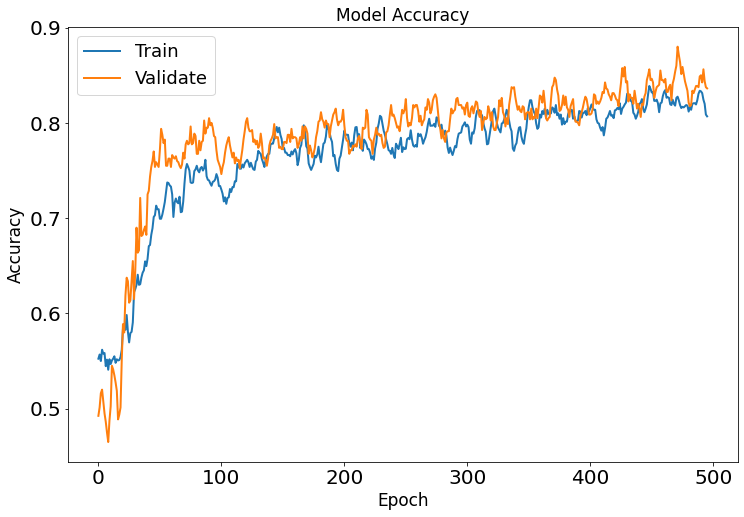

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Smoothed accuracy values
smoothed_train_acc = moving_average(history.history['accuracy'], window_size=5)
smoothed_val_acc = moving_average(history.history['val_accuracy'], window_size=5)

# Plotting the smoothed training accuracy and validation accuracy
plt.figure(figsize=(12, 8))
plt.plot(smoothed_train_acc, label='Train', linewidth=2)
plt.plot(smoothed_val_acc, label='Validate', linewidth=2)

# Set the font size for tick labels, legend, and axis labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=18)

# Set axis labels and title with larger font size
plt.title('Model Accuracy', fontsize=17)
plt.xlabel('Epoch', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)

# Display the plot
plt.show()


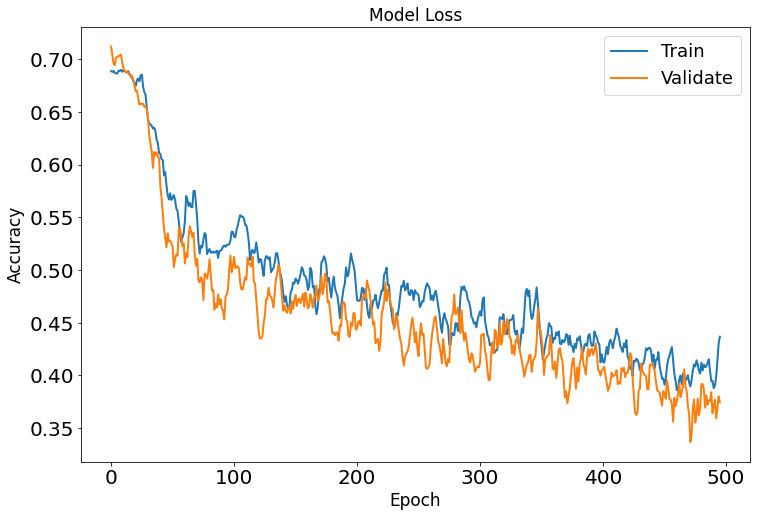

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Smoothed accuracy values
smoothed_train_acc = moving_average(history.history['loss'], window_size=5)
smoothed_val_acc = moving_average(history.history['val_loss'], window_size=5)

# Plotting the smoothed training accuracy and validation accuracy
plt.figure(figsize=(12, 8))
plt.plot(smoothed_train_acc, label='Train', linewidth=2)
plt.plot(smoothed_val_acc, label='Validate', linewidth=2)

# Set the font size for tick labels, legend, and axis labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=18)

# Set axis labels and title with larger font size
plt.title('Model Loss', fontsize=17)
plt.xlabel('Epoch', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)

# Display the plot
plt.show()


1/1 [==============================] - 0s 134ms/step
predicted_class 0, _ 0.18566015362739563
File: A0271.npy, Actual Label: 0, Predicted Label: 0
1/1 [==============================] - 0s 16ms/step
predicted_class 0, _ 0.048706889152526855
File: A0274.npy, Actual Label: 0, Predicted Label: 0
1/1 [==============================] - 0s 15ms/step
predicted_class 0, _ 0.05183819308876991
File: A0217.npy, Actual Label: 0, Predicted Label: 0
1/1 [==============================] - 0s 15ms/step
predicted_class 0, _ 0.05930867791175842
File: A0231.npy, Actual Label: 0, Predicted Label: 0
1/1 [==============================] - 0s 15ms/step
predicted_class 0, _ 0.06789398193359375
File: A0019.npy, Actual Label: 0, Predicted Label: 0
1/1 [==============================] - 0s 15ms/step
predicted_class 0, _ 0.06983386725187302
File: A0222.npy, Actual Label: 0, Predicted Label: 0
1/1 [==============================] - 0s 15ms/step
predicted_class 0, _ 0.03363819792866707
File: A0109.npy, Actual Label

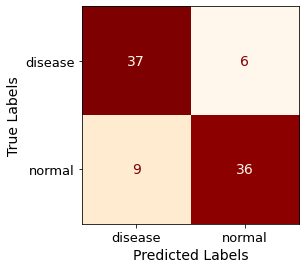

In [ ]:
#Proposed Testing Architecture

from keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from tensorflow.keras import layers
import cv2
import shutil
import scipy
from scipy.signal import butter, filtfilt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Normalization layer
nrmzln_layer = layers.experimental.preprocessing.Rescaling(1./255)

def create_image(file_path, save_dir):
    # Load file
    x = np.load(file_path)

    x= x[0][:5000]
    #x_size=np.array(x).flatten()

    if len(x) < 5000:
        print(f"Skipping file: {file_path} due to insufficient length.")
        return

    #sub_signal = signal[start_idx:end_idx]
    #normalized_array = (sub_signal / max(sub_signal)).clip(-1, 1)

    plt.figure(figsize=(1.60, 1.62))
    plt.plot(x, 'gray')
    plt.axis("off")

    sub_image_path = os.path.join(save_dir, f"{1}.png")
    plt.savefig(sub_image_path, bbox_inches='tight', pad_inches=0)
    plt.close()

#Image Processing and Classification by the Proposed CNN Model
def load_image(img_path, target_size=(124, 124)):
    img = image.load_img(img_path, target_size=target_size)

    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    nrmzln_layer = layers.experimental.preprocessing.Rescaling(1./255)
    img_tensor = nrmzln_layer(img_tensor)

    return img_tensor

def predict_class(model, img_path, threshold=0.28): #0.28 with ECG_Model_Lead_0_1d_cnn_0dot28 --> 82.95% acc. #misclassifications: 9 normal, 6 disease

    img_tensor = load_image(img_path)
    pred = model.predict(img_tensor)
    return 1 if pred >= threshold else 0, pred[0][0]

def evaluate_test_folder(model, test_folder):
    class_labels = sorted(os.listdir(test_folder))
    total_samples = 0
    correct_predictions = 0
    misclassifications = {0: 0, 1: 0}
    skipped_files = []
    true_labels = []
    predicted_probabilities = []

    for class_label in class_labels:
        class_path = os.path.join(test_folder, class_label)
        for npy_file in os.listdir(class_path):
            npy_path = os.path.join(class_path, npy_file)

            # Create three sub-images using create_image function
            save_dir = "path_to/temp_images/"
            create_image(npy_path, save_dir)

            for i in range(1, 2):
                sub_image_path = os.path.join(save_dir, f"{i}.png")
                predicted_class, _ = predict_class(model, sub_image_path)
                print(f"predicted_class {predicted_class}, _ {_}")

            # Get true class label based on folder name
            true_class = 0 if class_label == 'disease' else 1

            # Print details for each file
            print(f"File: {npy_file}, Actual Label: {true_class}, Predicted Label: {predicted_class}")

            # Print details for each image
            #print(f"Image: {image_file}, Actual Label: {true_class}, Predicted Label: {predicted_class}, Prediction Value: {prediction_value}")

            # Update metrics
            total_samples += 1
            correct_predictions += 1 if predicted_class == true_class else 0
            true_labels.append(true_class)
            predicted_probabilities.append(predicted_class)

            # Track misclassifications
            if predicted_class != true_class:
                misclassifications[true_class] += 1

    accuracy = correct_predictions / total_samples
    auc = roc_auc_score(true_labels, predicted_probabilities)

    print("True labels: ",true_labels)
    print("pred labels: ",predicted_probabilities)
    print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")
    print(f"AUC: {auc}")
    print("Misclassifications:")
    for class_label, count in misclassifications.items():
        print(f"Class {class_label}: {count} misclassifications")

    if skipped_files:
        print("\nSkipped Files:")
        for skipped_file in skipped_files:
            print(skipped_file)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_probabilities)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['disease', 'normal'])
    disp.plot(cmap='OrRd', values_format='d', ax=plt.gca(), colorbar=False)
    #plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    # Increase font size for the sample counts inside the matrix
    for text in disp.text_.ravel():
        text.set_fontsize(14)

    # Save the confusion matrix plot
    plt.savefig("path_to/confusion_matrix_lead_1.png", dpi=800, bbox_inches='tight')

    # Clean up temporary images
    files = glob.glob(r'path_to/folder/temp_images/*')
    for items in files:
        os.remove(items)

# Load the model
model_path = "path_to/model/ECG_Model_Lead_0.h5"
model = load_model(model_path)

# Test folder path
test_folder_path = 'path_to/test_folder/'

# Evaluate the test folder
evaluate_test_folder(model, test_folder_path)
